# Rip-One-Rule Algorithm

## Overview
The purpose of this code is to create a robust simple flexible Decision Rule algorithm. It combines elements from the two simplest Decisiton rule algorithms: OneR and Ripper. Unlike a deicsion tree, a decision rule algorithm is designed to find the best rules for sub-segments rather than finding the best overall set of rules to fit the entire population. As such it is suitable to fit a portion of the population or only a portion of the population. But it will find the best rules for that portion.

## Decision Rule Algorithms 
Decision Rules have largely gotten lost in the maelstrom of Machine Learning Techinques out there. I think for many there really isn't much of a need. As such there really is only one good overview of the topic that I was able to find: 
https://christophm.github.io/interpretable-ml-book/rules.html
Despite this I feel very strongly that there is a clear need for development in this area. The reason is implementability in the business world and the need for greater transparency in AI and ML overall. As such a decision rule algorithm can work in cases where decision trees or clustering algorithms can not. 

The existing algorithms lacked the flexibility to determine the "Best" rule that was necessary for the particular project this was developed for. It combines what I view as the best of the two most basic Decision Rule Algorithms: from OneRule it finds the best first rule and from Ripper it utilizes sequential covering. It that sense it is not particularly origional, but having a need for this particular kind of solution and not finding a good out of the box alternative I felt it was worth developing this tool in a general way. There is one more specific goal, the purpose of this algorithm is to generate the most bang for your buck. Not only do we want the best rules we want the fewest number of them, and we want to find them very quickly. This increases the number of threshold criteria, but allows for a control between speed and robustness.  

## Algorithm Overview
Speifically this algorithm utilizes a pandas dataframe rather than a Numpy matrix. There are two reasons for this. First, I want to keep the labeling attached and second I wanted to convert this to pyspark.  

The first thing the model does is to create (or is supplied) a list of feature variables and the name of a target. For now these variables must be categorical in nature. We will look to catagorizaiton schema for furture versions of this model.

### Sequential Covering 
0) We first start with an empty list of rules.  
1) Learn a rule. (See below)   
2) If you find a rule that meets criteria you add it to the list.  
3) Then remove all data points covered by rule.   
4) While the list of rules is below a certain quantity threshold or the last rule is above a quality threshold, you would find another rule. Else (go to 7).  
5) Learn another rule on the remaining data (return to 1).  
6) Return the decision list.  

### Rule Finding
1) It takes the first feature and does a group by on the table of that feature variable and the target and returns a valuation of that in a third column. This valuation can be chosen from any of the available aggregators in pandas agg (e.g. avg, sum, median etc.).   
2) Check if that rule meets basic thresholds (size and accuracy). If so keep, and decend to level 2 of  pruned tree search.  
3) Find a rule using the first feature and one of the other variables. If it meets the two basic thresholds and is greater than the top rule keep and decend again.   
4) If its not better or if it doesn't meet decent thresholds move to the next variable combination (Feature 1 and Feature 3).   
5) When all variable combinations have been exhausted for a given level move back up to the previous level.   
6) When you are back on level 1 continue on to the next feature and repeat 1-5, untill you have completed the entire list. Each time replacing the current best rule with another best rule and so on.   

Note on 1) There is even the possibility of custom evaluators. Be careful with these as they could radically slow your code.   
Note on 2) Unlike One rule not all categories are kept. As a result, this model will not cover the entire space with one rule.   
Other note on 2) If you want to find the true OneR rule, then set the size and accuracy thresholds to zero. This will not span the whole data set in one rule but will find the rule maximizing that potential, doing so however sets the speed of this algorithm to just over n^2

This will not create a decision set, but rather a decision list (order matters).
It can be done against all different values of the target but it is not necessarily recommended to do so. 

This whole process should be just under order n^2.

## Theoretical Background
The physical description of this process is like throwing coins into bags. The bags do not have to be the same size and the coins do not have to be two sided. From the binomial coefficient theorem we know that for this random system the possible range of combinations (number of coins, percent heads) are strongly dependent on each other. The smaller the sample size (number of coints) the much greater the range of coins coming up heads (percentage) is possible. These systems are likely too complicated to calcualte analytically. That is why an error checker is available to brute force the calculation. It will randomize your feature or target variable. and then rerun the calcualtion with the same thresholds (except that it will discard target labels and keep everything.) It then counts all the possible random combinations for the first rule. To make this calculation accurate you need to set much lower thresholds and also a depth limit (so it actually stops). What this will show for any case is that for small numbers of coinds in a bin there is no percentage which is statistically significant and for large bags the signficance is shockingly low. 


## Current Implementation

While there are other possible aggreagators, only two are implemented here. A straight up classifier that focuses on maximizing the accuracy of the rules that are selected and a gready aggregator that trys to maximize the sum of some value for each rule. The latter is best for situations where the type of object of interest connects to some positve value, and the other categories have some negative value. For example we could look at completed sales vs returned sales, where completed sales have some profit and the returns have a loss. In that case we could look to the greedy aggregator to maximise the target value with the minimum number of rules. In either case the size threshold is still important, though in the latter case particularly for early rules they will be maximally significant.


# Headers and Imports 

In [1]:
import pandas as pd
import numpy as np
import sys
import pickle
import numpy as np
import numpy.random
import matplotlib.pyplot as plt

# Import Data and Categorize

In [2]:
data_df = pd.read_csv("./iris_data.csv")
# data_df = pd.read_csv('./mushrooms.csv')

display(data_df.shape)
display(data_df.head(5))
display(data_df.dtypes)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

(150, 5)

,sepal length,sepal width,petal length,petal width,Class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


sepal length    float64
sepal width     float64
petal length    float64
petal width     float64
Class            object
dtype: object

# The Object Itself

Things not yet done:  
Heatmaps displaying wrong
Time Testing

In [6]:
class RipOneRule(object):
 
    def __init__(self, size_threshold = 1, agg_threshold = 0, feature_list = [], target = 'Target', 
                 target_value = 'Any', aggregator ='count', max_depth = -1, max_rules = -1, 
                 max_pop = sys.maxsize, rules_list = [],rules_value = [], rules_size = [], rules_target = [],
                 decent_flag = 'Both', stop_flag = 'Count', restart=False):
        if (aggregator != 'Count') and (aggregator != 'Sum'):
            print("Only implemented aggregators are Count which corresponds to average " +
                  "and Sum which is a cumulative (greedy) aggregator.")
        if restart == True:
            self.size_threshold = size_threshold 
            self.agg_threshold = agg_threshold 
            self.feature_list = feature_list
            self.target = target 
            self.target_value = target_value 
            self.aggregator = aggregator  
            self.max_depth = max_depth 
            self.max_rules = max_rules 
            self.max_pop = max_pop   
            self.prior_work_flag=True
        else:
            self.size_threshold = size_threshold 
            self.agg_threshold = agg_threshold 
            self.feature_list = feature_list
            self.target = target 
            self.target_value = target_value 
            self.aggregator = aggregator  
            self.max_depth = max_depth 
            self.max_rules = max_rules 
            self.max_pop = max_pop 
            self.rules_list = rules_list
            self.rules_value = rules_value
            self.rules_size = rules_size
            self.rules_target = rules_target
            self.prior_work_flag=True
 
            if self.aggregator == 'count':
                self.max_flag='percentage'
            else:
                self.max_flag=self.aggregator
    
    def fit(self, df): 
        total_pop =0 
        still_good=True
        df_work = df.copy()
        print("starting members  = ", df_work.shape[0])
            
        while still_good:
            Done = self.get_rule(df_work)
            condition = []
            for key,val in self.rules_list[-1].items():
                if len(condition) == 0:
                    condition = df_work[key] == val
                else:                        
                    condition = condition & (df_work[key] == val)
            df_work = df_work.loc[~condition,:]
            print("remaining members = ", df_work.shape[0])
            
            total_pop = total_pop - self.rules_value[-1]
 
            if len(self.rules_list) == self.max_rules:
                still_good= False
            if (self.target_value == 'Any') and (df_work.shape[0] == 0):
                still_good= False
            if ((self.target_value != 'Any') and 
                       (df_work.loc[df_work[self.target]==self.target_value,:].shape[0] == 0)):
                still_good= False
            if total_pop >= self.max_pop:
                still_good= False
            if Done:
                still_good= False
            
        print(self.rules_list)
        print(self.rules_size)
        print(self.rules_value)
        print(self.rules_target)
        
        return df, df_work
    
        del df_work
 
    def get_rule(self, df_work):
        depth=1
        #print("Depth = ", str(depth))
        Done = False
        var_list = []
        try_rule_list = []
        try_rule_size = []
        try_rule_value = []
        try_rule_target = []
        df_work[self.aggregator] = 0
        for feature in self.feature_list:
            value_df = df_work[[feature,self.target,self.aggregator]].groupby([feature,self.target]
                                                                    ).agg(self.aggregator).reset_index()
            if self.aggregator == 'count':
                count_df = value_df[[feature,self.aggregator]].rename({self.aggregator:'total'},axis=1
                                                                ).groupby([feature]).agg('sum').reset_index()
                temp_rules_df = pd.merge(value_df,count_df,how='left',on=feature) 
                temp_rules_df['percentage'] = temp_rules_df['count']/temp_rules_df['total']
            else:
                temp_rules_df= value_df    
            if self.target_value != 'Any':
                condition = temp_rules_df[target] == self.target_value
                temp_rules_df = temp_rules_df.loc[condition,:]
            temp_rules_df = temp_rules_df.loc[temp_rules_df['total'] > self.size_threshold,:]
            if (temp_rules_df[self.max_flag].max() > self.agg_threshold): 
                max_row = temp_rules_df[self.max_flag].idxmax()
                #print("Max_row = ",max_row)
                try_rule_list.append({feature: temp_rules_df.loc[max_row,feature]}.copy())
                try_rule_size.append(temp_rules_df.loc[max_row,'total'])
                try_rule_value.append(temp_rules_df.loc[max_row,'percentage'])  
#                 try_rule_value.append(temp_rules_df.loc[max_row,self.aggregator]]) 
                try_rule_target.append(temp_rules_df.loc[max_row,self.target])
            del temp_rules_df
            del value_df
            del count_df  
        if (len(try_rule_list) > 0):
            if (self.max_depth != 1):
                for ivar in range(len(try_rule_list)):
                    [try_rule_list[ivar],try_rule_size[ivar],try_rule_value[ivar],try_rule_target[ivar]] = \
                                    self.go_deeper(df_work, depth, try_rule_list[ivar],try_rule_size[ivar],
                                                   try_rule_value[ivar],try_rule_target[ivar])
            iBest = np.asarray(try_rule_value).argmax()
            self.rules_list.append(try_rule_list[iBest])
            self.rules_size.append(try_rule_size[iBest])
            self.rules_value.append(try_rule_value[iBest])
            self.rules_target.append(try_rule_target[iBest])
        else:
            Done = True
 
        del var_list
        del try_rule_list
        del try_rule_size
        del try_rule_value
        del try_rule_target
 
        #print("Dne = " ,Done)
    
        return Done 
 
    def go_deeper(self,df_work,depth,high_rule,high_rule_size,high_rule_value,high_rule_target):
        depth = depth + 1    
        #new_var_list = []
        try_rule_list = []
        try_rule_size = []
        try_rule_value = []
        try_rule_target = []
        for feature in self.feature_list:
            if feature in list(high_rule.keys()):
                continue
            value_df = df_work[list(high_rule.keys())+[feature,self.target,self.aggregator]].groupby(
                                list(high_rule.keys()) + [feature,self.target]
                                ).agg(self.aggregator).reset_index() 
            if self.aggregator == 'count':
                count_df = value_df[list(high_rule.keys())+[feature,self.aggregator]].rename(
                                    {self.aggregator:'total'},axis=1
                                    ).groupby(list(high_rule.keys())+[feature]).agg('sum').reset_index()
                temp_rules_df = pd.merge(value_df,count_df,how='left',on=list(high_rule.keys())+[feature]) 
                temp_rules_df['percentage'] = temp_rules_df['count']/temp_rules_df['total']
            else:
                temp_rules_df= value_df
                
            if self.target_value != 'Any':
                condition = temp_rules_df[target] == self.target_value
                temp_rules_df = temp_rules_df.loc[condition,:]
            
            temp_rules_df = temp_rules_df.loc[temp_rules_df['total'] > self.size_threshold,:]
            #display(temp_rules_df)
            
            if (temp_rules_df[self.max_flag].max() > self.agg_threshold):
                #display(temp_rules_df)
                max_row = temp_rules_df[self.max_flag ].idxmax()
                #print("max_row = ",max_row)
                var_list = list(high_rule.keys())+[feature]
                #print(var_list)
                rule_dict ={}
                for var in var_list:
                    rule_dict.update({var:temp_rules_df.loc[max_row,var]})
                try_rule_list.append(rule_dict)
                try_rule_size.append(temp_rules_df.loc[max_row,'total'])
                try_rule_value.append(temp_rules_df.loc[max_row,'percentage'])  
#                 try_rule_value.append(temp_rules_df.loc[max_row,self.aggregator]]) 
                try_rule_target.append(temp_rules_df.loc[max_row,self.target])
            del value_df
            del count_df
            
        if (len(try_rule_list) > 0): 
            if(self.max_depth != depth):
                for ivar in range(len(try_rule_list)):
                    [try_rule_list[ivar],try_rule_size[ivar],try_rule_value[ivar],try_rule_target[ivar]] = \
                                            self.go_deeper(df_work,depth,
                                            try_rule_list[ivar],try_rule_size[ivar],try_rule_value[ivar],
                                                          try_rule_target[ivar]) 
            # need to replace not append
            iBest = np.asarray(try_rule_value).argmax()
            if (try_rule_value[iBest] > high_rule_value):
                high_rule = try_rule_list[iBest]
                high_rule_value = try_rule_value[iBest]
                high_rule_size = try_rule_size[iBest]
                high_rule_target = try_rule_target[iBest]

        depth = depth-1
        #print("Depth = ", str(depth))
        
        return high_rule, high_rule_size, high_rule_value, high_rule_target
 
        del temp_rules_df
        del new_var_list
        del try_rule_list
        del try_rule_size
        del try_rule_value
 
    def predict(self, df):
        df['Rule Number'] = 0
        total_rules = len(self.rules_list)
        i=0
        for rule in reversed(self.rules_list):
            condition = []
            for key,val in rule.items():
                if len(condition) == 0:
                    condition = df[key] == val
                else:                        
                    condition = condition & df[key] == val
            df.loc[condition,'Rule Number'] = total_rules-i
            i=i-1
            
        return df
 
    # need to fix these next two
    def check_significance(self,df,scramble=False,scale=10):
        try_rule_list=[]
        Done=False
        depth=1
        counts_df = pd.DataFrame(columns=['total','percentage'])
        df_work = df.copy()
        df_work[self.aggregator] = 0
        if scramble:
            df_work[self.target] = np.random.permutation(df_work[self.target].values)
        for feature in self.feature_list:
            value_df = df_work[[feature,self.target,self.aggregator]].groupby([feature,self.target]
                                                                    ).agg(self.aggregator).reset_index()
            if self.aggregator == 'count':
                count_df = value_df[[feature,self.aggregator]].rename({self.aggregator:'total'},axis=1
                                                                ).groupby([feature]).agg('sum').reset_index() 
                temp_rules_df = pd.merge(value_df,count_df,how='left',on=feature) 
                temp_rules_df['percentage'] = temp_rules_df['count']/temp_rules_df['total']
            else:
                temp_rules_df= value_df
                
            if self.target_value != 'Any':
                condition = temp_rules_df[target] == self.target_value
                temp_rules_df =temp_rules_df.loc[condition,:]
            temp_rules_df = temp_rules_df.loc[temp_rules_df['total'] > self.size_threshold,:]
            if (temp_rules_df[self.max_flag].max() > self.agg_threshold): 
                try_rule_list.append(feature)
                counts_df = counts_df.append(temp_rules_df[counts_df.columns])
                if (self.max_depth != 1):
                    counts_df=counts_df.append(self.check_deep_layers(df_work,depth,[feature])
                                               [counts_df.columns])
        
        counts_df=counts_df.reset_index()
        
        #display(counts_df)
        
        self.significance_plot(counts_df,scale)
        
        del try_rule_list
        del value_df
        del temp_rules_df
        
        return counts_df
 
    def check_deep_layers(self,df_work,depth,high_rule):
        depth = depth+1
        try_rule_list = []
        new_counts_df = pd.DataFrame(columns=['total','percentage'])
        for feature in self.feature_list:
            if feature in high_rule:
                continue
            value_df = df_work[high_rule + [feature,self.target,self.aggregator]].groupby(
                               high_rule + [feature,self.target]).agg(self.aggregator).reset_index() 
            if self.aggregator == 'count':
                count_df = value_df[high_rule + [feature,self.aggregator]].rename({self.aggregator:'total'},axis=1
                                    ).groupby(high_rule + [feature]).agg('sum').reset_index()
                temp_rules_df = pd.merge(value_df,count_df,how='left',on=high_rule+[feature])
                temp_rules_df['percentage'] = temp_rules_df['count']/temp_rules_df['total']
            else:
                temp_rules_df= value_df
            
            if self.target_value != 'Any':
                condition = temp_rules_df[target] == self.target_value
                temp_rules_df = temp_rules_df.loc[condition,:]
            
            temp_rules_df = temp_rules_df.loc[temp_rules_df['total'] > self.size_threshold,:]
            
            if (temp_rules_df[self.max_flag].max() > self.agg_threshold):
                var_list = high_rule +[feature]
                new_counts_df = new_counts_df.append(temp_rules_df[new_counts_df.columns])
                if (self.max_depth != depth):
                    new_counts_df = new_counts_df.append(self.check_deep_layers(df_work,depth,var_list)
                                                                                    [new_counts_df.columns])
 
        depth = depth-1
        
        return new_counts_df 
 
        del try_rule_list
        del new_counts_df
        del more_counts_df
        del temp_rules_df
        del value_df
        del count_df
            
    def significance_plot(self,counts_df,scale=10,scramble=False):
        
        if scale >1:
            print("A scale of 10 is a 10x segmenter for fairly crude representations of the data field.")
            print("For finer representations a value of 5 or 2 is recommended.")
        else:
            print("Warning: scale is too fine. Recommended values are 10, 5, & 2. Quitting.")
            return
              
        # Create data
        x = counts_df['percentage']
        y = np.log10(counts_df['total'].astype('float'))

        # Create heatmap
        heatmap, xedges, yedges = np.histogram2d(x, y, bins=(100,100))
        extent = [xedges[0], xedges[5], yedges[0], yedges[1]]

        # Plot heatmap
        plt.clf()
        if scramble:
            plt.title('Random Significance Plot')
        else:
            plt.title('Real Significance Plot')    
        plt.ylabel('Total')
        plt.xlabel('Percentage')
        plt.imshow(heatmap, extent=extent)
        plt.show()

        # For use in tableau
        counts_df['count']=0
        counts_df[self.max_flag] = (10*scale*(counts_df[self.max_flag].round(2))).astype('int')
        counts_df['total'] = (10**((scale*np.log10(counts_df['total'].astype('float')).round(2)/scale)
                                  )).astype('int')
        counts_df = counts_df[['percentage','total','count']].groupby(['total','percentage']).count() \
                                .unstack(fill_value=0).stack().reset_index()
        display(counts_df)
        
        # save here for import into tableau heatmap
        if scramble:
            counts_df.to_csv("./rand_counts_scale" + str(scale) +".csv")
        else:
            counts_df.to_csv("./real_counts_scale" + str(scale) +".csv") 
                     
    def save_model(self,filename="./model.pkl"):
        pickle.dump(self, open(filename, 'wb'))
    
    def load_model(self,filename="./model.pkl"):
        self = pickle.load(open(filename, 'rb'))
        

# Run

Only implemented aggregators are Count which corresponds to average and Sum which is a cumulative (greedy) aggregator.
starting members  =  150
remaining members =  138
remaining members =  124
remaining members =  110
remaining members =  97
remaining members =  85
remaining members =  73
remaining members =  73
[{'petal length': 1.4}, {'petal length': 1.5}, {'petal width': 0.2}, {'petal width': 1.3}, {'petal width': 1.8}, {'petal width': 1.5}]
[12, 14, 14, 13, 12, 12]
[1.0, 1.0, 1.0, 1.0, 0.9166666666666666, 0.8333333333333334]
['Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-versicolor', 'Iris-virginica', 'Iris-versicolor']


,sepal length,sepal width,petal length,petal width,Class,Rule Number
0,5.1,3.5,1.4,0.2,Iris-setosa,11
1,4.9,3.0,1.4,0.2,Iris-setosa,11
2,4.7,3.2,1.3,0.2,Iris-setosa,9
3,4.6,3.1,1.5,0.2,Iris-setosa,10
4,5.0,3.6,1.4,0.2,Iris-setosa,11
5,5.4,3.9,1.7,0.4,Iris-setosa,0
6,4.6,3.4,1.4,0.3,Iris-setosa,11
7,5.0,3.4,1.5,0.2,Iris-setosa,10
8,4.4,2.9,1.4,0.2,Iris-setosa,11
9,4.9,3.1,1.5,0.1,Iris-setosa,10


Only implemented aggregators are Count which corresponds to average and Sum which is a cumulative (greedy) aggregator.
A scale of 10 is a 10x segmenter for fairly crude representations of the data field.
For finer representations a value of 5 or 2 is recommended.


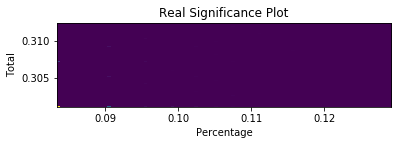

,total,percentage,count
0,1,1,0
1,1,2,0
2,1,3,0
3,1,4,0
4,1,5,0
5,1,6,0
6,1,7,0
7,1,8,0
8,1,9,0
9,1,10,62


A scale of 10 is a 10x segmenter for fairly crude representations of the data field.
For finer representations a value of 5 or 2 is recommended.


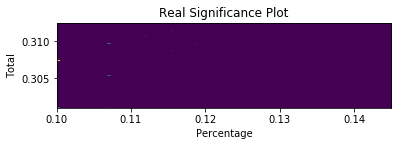

,total,percentage,count
0,1,2,0
1,1,3,0
2,1,4,0
3,1,5,0
4,1,6,0
5,1,7,0
6,1,8,0
7,1,9,0
8,1,10,492
9,1,11,0


In [7]:
clf = RipOneRule(feature_list = ['sepal length','sepal width','petal length','petal width'],target='Class',
                size_threshold = 8, agg_threshold = 0.8)
# clf = RipOneRule(feature_list = ['cap_shape','cap_surface','cap_color','bruises','odor','gill_attachment',
#                                  'gill_spacing','gill_size','gill_color','stalk_shape','stalk_root',
#                                  'stalk_surface_above_ring','stalk_surface_below_ring','stalk_color_above_ring',
#                                  'stalk_color_below_ring','veil_type','veil_color','ring_number','ring_type',
#                                  'spore_print_color','population','habitat'],target='type',
#                                   size_threshold = 8, agg_threshold = 0.8,max_depth=3)


results = clf.fit(data_df)

display(clf.predict(data_df))

clf = RipOneRule(feature_list = ['sepal length','sepal width','petal length','petal width'],target='Class',
                size_threshold = 1, agg_threshold = 0.0)
# clf = RipOneRule(feature_list = ['cap_shape','cap_surface','cap_color','bruises','odor','gill_attachment',
#                                  'gill_spacing','gill_size','gill_color','stalk_shape','stalk_root',
#                                  'stalk_surface_above_ring','stalk_surface_below_ring','stalk_color_above_ring',
#                                  'stalk_color_below_ring','veil_type','veil_color','ring_number','ring_type',
#                                  'spore_print_color','population','habitat'],target='type',
#                                   size_threshold = 1, agg_threshold = 0.0,restart=True,max_depth=3)

real_counts_df = clf.check_significance(data_df,scramble=False,scale=2)
random_counts_df = clf.check_significance(data_df,scramble=True,scale=2)

#print(results)
#print(clf)

# for mushroom set 
# y_mush = data['type']

# x_mush = data.loc[:,'cap_shape':]

# clf_mush = OneR()
# results = clf_mush.fit(x_mush, y_mush)



In [5]:
clf.save_model()